# 0 Setup, classes and functions

## 0.1 Libraries and data access

The first two code blocks load the required libraries and mounts the google drive data to access the data used.

In [48]:
# import libraries
import numpy as np
from numpy import sqrt, radians, arcsin, sin, cos, arctan2, pi # for the Haversine distance
import pandas as pd # for simple tables
import geopandas as gpd # to store geographic information in table format
import random # to generate random integers to test stuff
import matplotlib.pyplot as plt # for static plots
import timeit # for performance checks
import folium # to plot interactive maps (only for WGS84)
from collections import Counter # to count things
import shapely # to access the NYC street network multiline data

pd.set_option('display.max_colwidth', None)

In [49]:
# access the required files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Classes

The following code builds on the classes we set up during the exercises in the course.

In [50]:
####### Point #######
class Point:
    '''
    contains an x and a y value
    '''
    # initialise
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y

    # representation
    def __repr__(self):
        return f"Point(x={self.x}, y={self.y})"

    # Test for equality between Points
    def __eq__(self, other):
        if not isinstance(other, Point):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.x == other.x and self.y == other.y

    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.x, self.y))

    # define a method to calculate the determinant
    def determinant(self, p, q):
        det = (
            self.x * p.y
            - p.x * self.y
            + q.x * self.y
            - self.x * q.y
            + p.x * q.y
            - q.x * p.y
        )
        # build conditions to return -1, 1 or 0 for right, left, collinear
        if det > 0:
            detV = "left"
        elif det < 0:
            detV = "right"
        else:
            detV = "col"
        return detV

    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)

    # calculate Manhattan distance between two points
    def distManhattan(self, other):
        return abs(self.x - other.x) + abs(self.y - other.y)

    # Haversine distance between two points on a sphere - requires lat/lng converted to radians
    def distHaversine(self, other):
        r = 6371000  # Earth's radius in metres (will return result in metres)
        phi1 = radians(self.y)  # latitudes
        phi2 = radians(other.y)
        lam1 = radians(self.x)  # longitudes
        lam2 = radians(other.x)

        d = (
            2
            * r
            * arcsin(
                sqrt(
                    sin((phi2 - phi1) / 2) ** 2
                    + cos(phi1) * cos(phi2) * sin((lam2 - lam1) / 2) ** 2
                )
            )
        )
        return d


####### Segment #######
class Segment:
    '''
    contains a start and an end point
    '''
    # initialise
    def __init__(self, p0, p1):
        self.start = p0
        self.end = p1
        self.length = p0.distEuclidean(p1)

    # representation
    def __repr__(self):
        return f"{self.start} -- {self.end}"

    def get_length(self):
        len = self.start.distEuclidean(self.end)
        return len

    # setting up this one to be able to get the length of a segment in WGS84
    def get_length2(self):
        len = self.start.distHaversine(self.end)
        return len

    # Test for equality between Segments - we treat segments going in opposite directions as equal here (so direction doesn't matter)
    def __eq__(self, other):
        if (self.start == other.start or self.start == other.end) and (
            self.end == other.end or self.end == other.start
        ):
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries

    def __hash__(self):
        return hash((self.start.x, self.start.y, self.end.x, self.end.y))

    def plot_segment(self, linecolor=None):
        # build x and y representation
        x = [self.start.x, self.end.x]
        y = [self.start.y, self.end.y]
        plt.gca().set_aspect("equal")
        plt.plot(x, y, linestyle="-", marker="o", color="black", label="street segment")
        plt.legend()
        plt.show()

    def get_segment_Bbox_intersect(self, other):
        # convert segments into Bbox class
        sBbox = Bbox([self.start, self.end])
        oBbox = Bbox([other.start, other.end])
        # return if intersect or not by calling the method from the Bbox class: returns True if intersection
        return sBbox.intersects(oBbox)

    # determine if segment intersects with another segment
    def intersects(self, other):
        # print(f'Method not yet defined, will always return false')
        # return False
        # first get the determinant of the first segment and the first point of segment 2
        a = self.start
        b = self.end
        p = other.start
        q = other.end
        det1 = a.determinant(b, q)
        det2 = a.determinant(b, p)
        det3 = p.determinant(q, a)
        det4 = p.determinant(q, b)
        # one condition has to be fulfilled to know if they intersect
        if det1 != det2 and det3 != det4:
            return "condition1 met: they intersect"
        elif det1 == det2 == det3 == det4 == "col" and self.get_segment_Bbox_intersect(
            other
        ):  # and bbox intersection
            return "condition 2 met: collinear and shared bbox"
        else:
            return 0


####### Bounding Box #######
class Bbox:
    '''
    takes a list of Points or a list of Segments anc calculats the bounding box
    '''
    # initialise
    def __init__(self, data):
        # using built-in `isinstance` to test what class has been used to initialise the object
        # for Segment objects
        if isinstance(data, Segment) == True:
            x = [data.start.x, data.end.x]
            y = [data.start.y, data.end.y]
        else:  # for PointGroup objects (e.g. Polygons)
            x = [i.x for i in data]  # extract all x coords as a list
            y = [i.y for i in data]  # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))  # lower-left corner (min x, min y)
        self.lr = Point(max(x), min(y))
        self.ul = Point(min(x), max(y))
        self.ur = Point(max(x), max(y))  # upper-right corner (max x, max y)
        self.ctr = Point((max(x) - min(x)) / 2, (max(y) - min(y)) / 2)  # centre of box
        self.area = (abs(max(x) - min(x))) * abs((max(y) - min(y)))  # area of box
        self.horlen = self.ll.distHaversine(self.lr)
        self.verlen = self.ll.distHaversine(self.ul)
        self.points = [self.ll, self.lr, self.ur, self.ul, self.ll]

    # plot the bbox
    def plot_bbox(self):
        for i in range(len(self.points) - 1):
            p1 = self.points[i]
            p2 = self.points[i + 1]
            plt.plot(
                [p1.x, p2.x],
                [p1.y, p2.y],
                linestyle="dotted",
                marker="o",
                color="orange",
            )
        plt.show()

    # representation
    def __repr__(self):
        return f"Bounding box with lower-left {self.ll} and upper-right {self.ur}"

    def __eq__(self, other):
        if self.ll == other.ll and self.ur == other.ur:
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries

    def __hash__(self):
        return hash(self.ll, self.ur)

    # test for overlap between two bounding boxes
    def intersects(self, other):
        # test if bboxes overlap (touching is not enough to be compatible with the segment approach)
        if (
            self.ur.x > other.ll.x
            and other.ur.x > self.ll.x
            and self.ur.y > other.ll.y
            and other.ur.y > self.ll.y
        ):
            return True
        else:
            return False

    # test for point bbox intersection
    def containsPoint(self, p):
        if (
            self.ur.x >= p.x
            and p.x >= self.ll.x
            and self.ur.y >= p.y
            and p.y >= self.ll.y
        ):
            return True
        return False



##### Point Groups #####

class PointGroup:
    '''
    takes a list of lists with [x,y] value
    '''
    # initialise
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))

    # representation
    def __repr__(self):
        return f"PointGroup containing {self.size} points"

    # create index of points in group for referencing
    def __getitem__(self, key):
        return self.points[key]


##### Polygon #####

class Polygon(PointGroup):
    '''
    takes a list of lists with [x,y] value
    '''
    # initialise
    def __init__(self, data=None, xcol=0, ycol=1):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
        self.bbox = Bbox(self)

    # representation
    def __repr__(self):
        return f"Polygon PointGroup containing {self.size} points with the self.points list: {self.points}"

    # test if polygon is closed: first and last point should be identical
    def isClosed(self):
        start = self.points[0]
        end = self.points[-1]
        return start == end

    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points))  # Get rid of the duplicates
        self.points.append(
            self.points[0]
        )  # Our polygon must have one duplicate - we put it back now
        n = len(self.points)

    def __signedArea( # based on GIS Algorithms, Ch.2 p9-10, by Ningchuan Xiao, publ. 2016
        self,
    ):  # used for both area and centre calculations - this is a private method (only used within the class)
        a = 0
        xmean = 0
        ymean = 0
        for i in range(0, self.size - 1):
            ai = self[i].x * self[i + 1].y - self[i + 1].x * self[i].y
            a += ai
            xmean += (self[i + 1].x + self[i].x) * ai
            ymean += (self[i + 1].y + self[i].y) * ai

        a = a / 2.0  # signed area of polygon (can be negative)

        return a, xmean, ymean

    def area(self):
        a, xmean, ymean = self.__signedArea()
        area = abs(a)  # absolute area of polygon

        return area

    def centre(self):
        a, xmean, ymean = self.__signedArea()  # note we use the signed area here
        centre = Point(xmean / (6 * a), ymean / (6 * a))  # centre of polygon
        return centre

    def plot_polygon(self):
        # self.points is a list of Point objects where the first point equals the last point.. thus make self.points-1
        for i in range(len(self.points) - 1):
            p1 = self.points[i]
            p2 = self.points[i + 1]
            plt.plot(
                [p1.x, p2.x],
                [p1.y, p2.y],
                linestyle="dotted",
                marker="o",
                color="orange",
            )
        plt.show()

    # Ray method (even odd): polygon point intersection
    def containsPoint(self, p, plotit=False):
        if plotit:
            for i in range(len(self.points) - 1):
                p1 = self.points[i]
                p2 = self.points[i + 1]
                plt.plot(
                    [p1.x, p2.x],
                    [p1.y, p2.y],
                    linestyle="dotted",
                    marker="o",
                    color="orange",
                )
            plt.scatter(p.x, p.y)
            plt.show()
        elif self.bbox.containsPoint(p) == False:
            return False
        else:
            ray = Segment(p, Point(x=self.bbox.ur.x + 1, y=p.y))
            n = self.size
            count = 0
            for i in range(n - 1):
                if self[i].y != self[i + 1].y:
                    s = Segment(self[i], self[i + 1])
                    if s.intersects(ray) != 0:
                        y_start = self[i].y
                        y_end = self[i + 1].y
                        if p.y != min(y_start, y_end):
                            count = count + 1
            if count % 2 == 0:
                return False
            else:
                # print('INSIDE')
                return True

    # another point in polygon intersection method that only works for rectangles (using determinant)
    def alwaysLeft(self, point):
        if (
            self[0].determinant(self[1], point)
            == self[1].determinant(self[2], point)
            == self[2].determinant(self[3], point)
            == self[3].determinant(self[4], point)
        ):
            return True
        else:
            return False


## 0.3 Functions

The following sections contain standalone functions that were used for the subtasks, e.g.:
- simple data manipulation (e.g. for street network data, Flickr photos, etc.)
- buffer polygon calculation in WGS 84
- spatial index creation in WGS 84

Our code isn't fully object-oriented as we find functions easier to test or verify certain steps. Although we started the conversion of the code into an object-oriented format (e.g. setting up a class for the buffered segments), time capacity was too tight to convert everything. Thus, we decided to keep it cohesive and mainly worked with functions. However, if we had more time, we probably would have created additional classes for the buffers or the spatial index.

In [51]:
### Street network manipulation functions ###

# 1. Split multiline into segments
def split_segments(multiline):
    '''
    Takes the shapely multiline strings of the street network and splits it up into individual segments
    '''
    segs = []
    for linestr in list(multiline.geoms):
        arr = linestr.coords.xy # access the shapely geometries
        for node in range(len(arr[0]) - 1):
            # create segments going from all p0 to p1
            segs.append(
                Segment(
                    Point(arr[0][node], arr[1][node]),
                    Point(arr[0][node + 1], arr[1][node + 1]),
                )
            )
        # print(segs)
        return segs


### Sound tags & sound category functions ###

# 1. sound category frequencies
def get_major_category(taglist, lexdict):  # taglist = all tags per segments in one list
    '''
    takes the list of tags (of a certain segment) and the sound term lexicon and returns the most prevalent category numbers
    '''
    if taglist is not None:  # those buffers without photos or without relevant sound tags don't matter
        catnr = []  # the category number (e.g. 3: human)
        for tag in taglist:
            catnr.append(lexdict[tag])
        countcat = Counter(catnr)
        # get most common values and their counts
        most_common = countcat.most_common()
        # get only those values that are most often (several ones if there are two 'most frequent ones')
        most_common_cat = [value for value, count in most_common if count == most_common[0][1]]
        # returns the category numbers and their frequencies
        return most_common_cat

# 2. to get the overall frequency counts of all sound tags mentioned by Flickr users
def get_alltag_frequency(taglist, lexdict):  # taglist = all tags per segments in one list
    '''
    get the frequency distribution of all sound tags that Flickr users mentioned (in our dataset)
    '''
    if taglist is not None:  # those buffers without photos don't matter
        catnr = []
        for tag in taglist:
            if tag in lexdict:
                soundtags.append(tag)
                catnr.append(lexdict[tag])
        major_cat = Counter(catnr).most_common(6)  # gets only the major cat
        return major_cat

# 3. choice in case of equal frequency tags
def get_1category(ex, catdict):
    """

    takes a list containing the categorynr(s) of the most frequent category/categories, e.g. [3, 5]
    in the above example, the function would return 5 since people overall mentioned category five less often (this is our "respect minority" approach)

    """
    if len(ex) == 0: # if no photos or no valid sound tags in the segment
        return 0.0
    elif len(ex) == 1: # if only one category in the segment
        onlycat = ex[0]
        return onlycat
    else:
        maxratio = 0
        maxcat = 42
        for cat in ex:
            category = cat
            frequency = 1 # number here doesn't matter since frequency is the same if we have two most common categories
            freqratio = frequency/catdict[category]
            if freqratio > maxratio:
                maxratio = freqratio
                maxcat = category
        return maxcat


# 3. color codes for mapping
def colorcode(maincat):
    '''
    simply adds the category names and respective colors
    '''
    if maincat == 0.0:
        return [
            "grey",
            "no category",
        ]  # No photos in buffer or no sound tags in buffer photos
    if maincat == 1.0:
        return ["brown", "transport"]  # motorized
    if maincat == 2.0:
        return ["green", "nature"]  # nature
    if maincat == 3.0:
        return ["blue", "human"]  # human
    if maincat == 4.0:
        return ["purple", "music"]  # music
    if maincat == 5.0:
        return ["yellow", "indoor"]  # indoor
    if maincat == 6.0:
        return ["black", "mechanical"]  # mechanical




### WGS84 functions to calculate buffer corner points ###

# 1. calculate the bearing between two wgs84 points
def calculate_bearing(lat1, lon1, lat2, lon2):
    '''
    calculates the bearing (azimuth) of a point in relation to another point (edge start and end point)
    '''
    X = cos(radians(lat2)) * sin(radians(lon2 - lon1))
    Y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(
        radians(lat2)
    ) * cos(radians(lon2 - lon1))
    bearing = arctan2(X, Y)
    bearing_degrees = (bearing * 180 / pi + 360) % 360
    perp1 = bearing_degrees + 90
    perp2 = bearing_degrees - 90
    return bearing_degrees


# 2. get the perpendicular bearing in both directions
def get_perpendiculars(bearing):
    '''
    Simply takes the bearing and returns the perpendicular bearings to it
    '''
    # bearing in degrees
    perp1 = bearing + 90
    perp2 = bearing - 90
    if perp1 >= 360:
        perp1 = perp1 - 360
    if perp1 < 0:
        perp1 = 360 + perp1
    if perp2 >= 360:
        perp2 = perp2 - 360
    if perp2 < 0:
        perp2 = 360 + perp2
    return perp1, perp2


# 3. calculate destination point in WGS84
def get_destination(startx, starty, bearing, distance, r=6371000):
    '''
    Calculates the destination point in WGS84 given a start point, a distance and the bearing of the desired destination as well as the earth radius
    '''
    # convert to rad
    startx, starty, bearing = radians(startx), radians(starty), radians(bearing)
    # y coordinate of destination
    desty = arcsin(
        sin(starty) * cos(distance / r) + cos(starty) * sin(distance / r) * cos(bearing)
    )
    desty_degrees = desty * 180 / pi
    # x coordinate of destination
    destx = startx + arctan2(
        sin(bearing) * sin(distance / r) * cos(starty),
        cos(distance / r) - sin(starty) * sin(desty),
    )
    destx_degrees = destx * 180 / pi
    return desty_degrees, destx_degrees


# 3. get the buffer of a segment in WGS84
def get_buffer(seg, bufferwidth):
    '''
    this function makes use of the two above functions
    it first calculates the bearings of the segment (in both directions)
    then, it calculates the corner points of the buffer
    the buffer is returned in a format that is directly plottable in folium maps
    '''
    A = seg.start  # this is A
    B = seg.end  # this is B

    # calculate bearing away from start (A) and away from end point (B)
    br_A = calculate_bearing(
        A.y, A.x, B.y, B.x
    )  # Azimuth Winkel in Punkt A, richtung B
    br_B = calculate_bearing(
        B.y, B.x, A.y, A.x
    )  # Azimuth Winkel in Punkt B, richtung A

    # use these bearings to get the points (given start, end, bearing and distance)
    B_new = get_destination(B.x, B.y, br_A, bufferwidth)
    A_new = get_destination(A.x, A.y, br_B, bufferwidth)

    # from these new extension points, calculate the four corner points using the perpendicular bearings -- are the same from B and from A
    perp1, perp2 = get_perpendiculars(br_B)

    # now get the two corners from A and from B (names: A1, B2, B3, A4; anti-clockwise)
    A1 = get_destination(A_new[1], A_new[0], perp2, bufferwidth)
    A4 = get_destination(A_new[1], A_new[0], perp1, bufferwidth)
    B2 = get_destination(B_new[1], B_new[0], perp2, bufferwidth)
    B3 = get_destination(B_new[1], B_new[0], perp1, bufferwidth)

    return [
        A1,
        B2,
        B3,
        A4,
        A1,
    ]  # Attention: in lat/lon (y/x) order for folium plotting


# 4. converts the lat/lon buffer into lon/lat buffer representation
def convert_to_x_y(bufferpoly):
    '''
    this function simply converts the representation of the buffer
    '''
    newcorners = []
    for corner in bufferpoly:
        newcorner = (corner[1], corner[0])
        newcorners.append(newcorner)
    return Polygon(newcorners)



### WGS84 grid for spatial indexing ###

# create a grid for the spatial indexing
def create_grid(bbox, to_right, to_top, res):
    '''
    this function creates the spatial index and takes the number of cells to the right and to the top
    as well as the resolution and the network bounding box into consideration
    '''
    cells = []  # this list stores all cells as BBox
    cellnr = []
    startll = bbox.ll
    ll_zwischenspeicher = bbox.ll  # the first ll is the one of the big bbox
    for t in range(to_top):  # first start at the bottom line
        startll = ll_zwischenspeicher  # executed whenever going one cell up
        # move horizontalle to the right
        for r in range(to_right):
            # based on ll, calculate lr using Haversine
            cell_lr = get_destination(
                startx=startll.x, starty=startll.y, bearing=90, distance=res
            )
            cell_lr = Point(x=cell_lr[1], y=cell_lr[0])
            # based on ll, calcualte ul using Haversine
            cell_ul = get_destination(
                startx=startll.x, starty=startll.y, bearing=0, distance=res
            )
            cell_ul = Point(x=cell_ul[1], y=cell_ul[0])
            # based on previous ones, calcualte ur using Haversine
            cell_ur = get_destination(
                startx=cell_ul.x, starty=cell_ul.y, bearing=90, distance=res
            )
            cell_ur = Point(x=cell_ur[1], y=cell_ur[0])
            if r == 0:  # the ul of the most left cell becomes the ll of the next row
                ll_zwischenspeicher = cell_ul
            # save cell as bbox
            cell_bbox = Bbox([cell_lr, cell_ul, startll, cell_ur])
            # save cell numer and the cell itself in lists
            cells.append(cell_bbox)
            cellnr.append(t * (to_right) + (r + 1))
            # lower left corner updaten
            startll = cell_lr
    return cellnr, cells


# intersect photos with all grid cells using a dictionary (faster!)
def store_photos_v1(griddf, coordic):
    '''
    this function stores all the photos in the grid cells
    '''
    idcol = []
    # get first cellbox in griddf
    for cellbox in griddf["cellbox"]:
        containedID = []
        # get the first photo id
        for id in coordic.keys():
            # get coordinates of the photo id
            photoloc = coordic[id]
            # intersect cellbox with photo coordinates
            if cellbox.containsPoint(photoloc):
                containedID.append(id)
        idcol.append(containedID)
    return idcol


# test for segment buffer cell intersection using dictionaries
def segment_cell_intersection(df, cellboxdict, cellphotodict):
    '''
    this function checks for intersection between the street segments and the grid cells
    it then assigns the respective grid cells to the segment and their buffers
    '''
    splist = []
    sclist = []
    # for the first segment buffer bbox
    for bfbox in df["bfbox"]:
        cellsOI = []
        photosOI = []  # photos of cells that intersect with the segment buffers
        # for the first cellbox, test for intersection with the first segment buffer box
        for cellnr in cellboxdict.keys():
            cellbox = cellboxdict[cellnr]
            if bfbox.intersects(cellbox):
                # if they intersect, add the cells photos to the photos of interest
                cellphotos = cellphotodict[cellnr]
                photosOI.append(cellphotos)
                cellsOI.append(cellnr)
        sclist.append(cellsOI)
        splist.append(photosOI)
    return sclist, splist


# plot a segment buffer, the cells it intersects with and the photos in that cell
import folium

def plot_dfsub_row(nr, bbox, dfsub, gridict, tagdic, coordic):
    '''
    this function is used to create a folium plot for verification
    the plot then shows a chosen segment buffer, the cell it intersects with and the cells photos
    furthermore, the photos inside the buffer are plotted in red
    '''
    center = dfsub["cellsOI"][nr][0]
    center = gridict[center].ll
    m = folium.Map(
        location=[center.y, center.x], zoom_start=14, tiles="CartoDB positron"
    )  # CartoDB voyager, dark_matter, positron, Openstreetmap
    # the big box
    locations = [
        [bbox.ll.y, bbox.ll.x],
        [bbox.lr.y, bbox.lr.x],
        [bbox.ur.y, bbox.ur.x],
        [bbox.ul.y, bbox.ul.x],
    ]
    folium.Polygon(
        locations=locations,
        color="blue",
        weight=3,
        fill_color="grey",
        fill_opacity=0.5,
        fill=True,
        popup="The street bounding box",
        # tooltip="Click me!",
    ).add_to(m)
    for l in dfsub["cellsOI"][
        nr
    ]:  # list of cell numbers that intersect the segment buffer, e.g. [1102, 1103]
        cell = gridict[l]
        corners = [
            [cell.ll.y, cell.ll.x],
            [cell.lr.y, cell.lr.x],
            [cell.ur.y, cell.ur.x],
            [cell.ul.y, cell.ul.x],
        ]
        folium.Polygon(
            locations=corners,
            color="black",
            weight=1,
            fill_color="yellow",
            fill_opacity=0.2,
            fill=True,
            popup=f"cell nr {str(l)}",
            # tooltip="Click me!",
        ).add_to(m)
    # the corresponding segment buffer
    buf = dfsub["buffers_y_x"][nr]
    # loc = [[buf[0].y, buf[0].x], [buf[1].y, buf[1].x], [buf[2].y, buf[2].x], [buf[3].y, buf[3].x], [buf[4].y, buf[4].x]]
    folium.Polygon(
        locations=buf,
        color="red",
        weight=6,
        fill_color="red",
        fill_opacity=0.5,
        fill=True,
        popup=f"Street segment buffer of row {str(nr)}",
        # tooltip="Click me!",
    ).add_to(m)
    # the photos belonging to the cell
    plist = dfsub["photosOI"][nr]
    # print(f"==>> plist: {plist}")
    for j in plist:
        jcoord = coordic[j]
        jtags = tagdic[j]
        folium.CircleMarker(
            location=[jcoord.y, jcoord.x],
            tooltip=str(jtags),
            color="black",
            radius=3,
            popup=f"Photo id:\n {str(j)}",
        ).add_to(m)
    # the photos that actually intersect with the segment buffer
    segphotos = dfsub["pidIB"][nr]
    if len(segphotos) != 0:
        for p in segphotos:
            coord = coordic[p]
            tags = tagdic[p]
            folium.CircleMarker(
                location=[coord.y, coord.x],
                color="red",
                radius=3,
                tooltip=str(tags),
                popup=f"Photo id:\n {str(p)}",
            ).add_to(m)
    return m

1 Load and pre-process data

# 1 Load and pre-process data




## 1.1 Street data

In the first step, the official New York City street network is loaded in. The data was acquired from the [New York City data portal](https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b).

In [52]:
# import the New York street network data
path1 = r"drive/MyDrive/geo877/nycstreets.geojson"
ny = gpd.read_file(path1)

By plotting the street network data, one can see that some ship routes are also part of it.

In [53]:
boro = {'1':'Manhattan', '2':'Bronx', '3':'Brooklyn', '4':'Queens', '5':'Staten Island'}
ny['district'] = ny['borocode'].apply(lambda x: boro[x])

<Axes: >

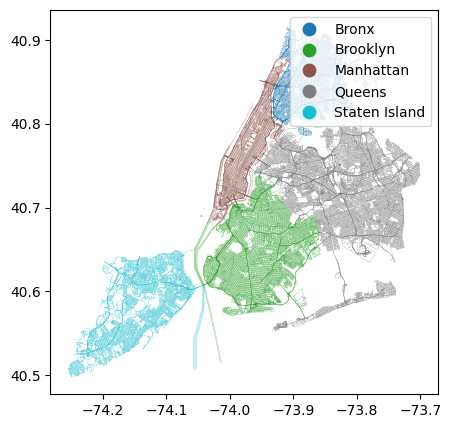

In [54]:
# plot the New York street network colorised by their districts to get an impression of the extent
ny.plot(figsize=(5,10), column='district', lw=0.175, cmap='tab10', legend=True)

The street network data contains Shapely multiline objects. Most of these streets consist of more than two vertices. Since we need individual segments (exactly two vertices: start and end), those multilines have to be split up.

Via the ***split_segments*** function,  those individual vertices of the shapely multilines are accessed. For this part, the Shapely package is required.
We store the segments in the list called ***allsegs***.




In [55]:
# split up the Shapely multilines of the New York network into single segments
allsegs = []
for ml in ny['geometry']:
    segments = split_segments(ml)
    allsegs.append(segments)
# store the segments in a list
allsegs = [i for x in allsegs for i in x]

print(f'The initial {len(ny)} street data was split up into {len(allsegs)} segments.')

The initial 121911 street data was split up into 290248 segments.


To later assign the Flickr photos (and especially their tags) to the respective street segments, the segments need to be buffered. This is done by the ***get_buffer*** function which takes the **bearing** of a given segment to be able to deal with **WGS84** coordinates. Similar to *Aiello et al. (2016)*, we take a buffer width of 20 meters. As a result, a list of five points is returned which represent the corner points of the buffer in a cycle whereas the first point equals the last point. We also change the representation of the buffer (switching lat and lon, for plotting purposes) and store both buffer representations in two lists.

In [56]:
# convert segments to buffers (in x_y and y_x for folium plotting)
allbuff_y_x = []
allbuff =[]
for seg in allsegs:
    b1 = get_buffer(seg, bufferwidth=20)
    allbuff_y_x.append(b1)
    b2 = convert_to_x_y(b1)
    allbuff.append(b2)

We store the segments and their corresponding buffers (in both representations) in our main dataframe called ***df***. Eventually, each segment in this df will get a column with all photos its buffer intersects with and the corresponding tags of those intersected photos.

In [57]:
# create a DF containing the segments and the corresponding buffers
df = pd.DataFrame()
df['segments'] = allsegs
df['buffers_y_x'] = allbuff_y_x
df['buffers'] = allbuff

print('The df currently contains the following columns: ', [col for col in df.columns])
print(f'Here is the first row of the df as an example.')
df.head(1)

The df currently contains the following columns:  ['segments', 'buffers_y_x', 'buffers']
Here is the first row of the df as an example.


,segments,buffers_y_x,buffers
0,"Point(x=-73.90600778422906, y=40.80739863619749) -- Point(x=-73.90570127697174, y=40.80761650259427)","[(40.807144394818216, -73.9060183367097), (40.80760851575213, -73.90536538295231), (40.80787074394443, -73.9056907256288), (40.807406623010515, -73.90634367711077), (40.807144394818216, -73.9060183367097)]","Polygon PointGroup containing 5 points with the self.points list: [Point(x=-73.9060183367097, y=40.807144394818216), Point(x=-73.90536538295231, y=40.80760851575213), Point(x=-73.9056907256288, y=40.80787074394443), Point(x=-73.90634367711077, y=40.807406623010515), Point(x=-73.9060183367097, y=40.807144394818216)]"


## 1.2 Sound terms

In a second step, we read in the sound terms which will later be matched with the tags found in the Flickr photo data. We used the author's sound lexicon ([here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.tg735)) and manually added suitable words (e.g. derivates of existing sound terms) and checked the photo tags to expand the lexicon. All manually added words were also categorised into the existing classes, that being:

*   transport (e.g. subway)
*   nature (e.g. bird)
*   human (e.g. walk)
*   music (e.g. musician)
*   indoor (e.g. church)
*   mechanical (e.g. construction)










In [58]:
# load the file that contains sound terms and their categorization
path2 = r"drive/MyDrive/geo877/revised_sound_lexicon_v3.csv"
# 'latin1' encoding is used for the spanish words which have unknown character for utf-8 encoding
lex = pd.read_csv(path2, encoding='latin1')

Since only the sound term and the respective category are of interest, we converted the data frame into a dictionary since python dictionaries are faster to retrieve information from. This dictionary is called ***sounddict***.

In [59]:
# create a dictionary with words as keys and category as values
sounddict = dict(zip(lex.Lexicon, lex.Category))

print(f'In total, there are {len(sounddict)} sound terms in the updated lexicon.')

In total, there are 780 sound terms in the updated lexicon.


## 1.3 Photo data

As our last data source, we read in the photo data we downloaded from [Flickr](https://www.flickr.com/). We used the Flickr API and a bounding box of New York to retrieve georeferenced photos which were uploaded between 2009 and May 2024.


In [60]:
# load the Flickr photo dataset
path3 = r"drive/MyDrive/geo877/flickr_data150k.json"
photos_full = pd.read_json(path3, lines=True)

print(f'There are a total of {len(photos_full)} photos.')
print('Here is a glimpse at the photo dataset:')
photos_full.head(1)

There are a total of 150719 photos.
Here is a glimpse at the photo dataset:


,ï»¿user_id,photo_id,photo_title,tags,latitude,longitude,description,date_taken,date_upload,url_o,farm,server,secret,has_tags
0,157788534@N08,51018936608,Rumored Haunted,hauntedhouse faps,40.532581,-74.238256,"{'_content': 'The landmarked Kreischer Mansion; Charleston, Staten Island. \n\n<a href=""https://en.wikipedia.org/wiki/Kreischer_House"" rel=""noreferrer nofollow"">Wikipedia</a> page.\n\n<a href=""https://www.youtube.com/watch?v=Hx4NK6wRYc8"" rel=""noreferrer nofollow"">YouTube</a>, includes interior shots.'}",2013-03-09 14:16:53,2021-03-09 16:39:54,https://live.staticflickr.com/65535/51018936608_cdd3d61431_o.jpg,66,65535,c005c28dd1,1


In the following code block, we check for errors that potentially happened during the concatenation process when the numerous photo datasets were glued together. Additionally, potential photo duplicates are removed in case there are any. Finally, we selected only the relevant columns of the photo data. This data frame is simply called ***photos***.

In [61]:
# correct an concatenation error in line 201 by eliminating this row (attention: just rerun this if it raises the error 'list object can't use 'split')
photos_full = photos_full[photos_full['longitude'] != 'longitude']

# remove duplicate photo ids in case there are any
photos = photos_full.drop_duplicates(subset=['photo_id'], keep='first')
photos = photos.reset_index()
if len(photos_full) > len(photos):
  print(f'There are now {len(photos)} photos. {len(photos_full)-len(photos)} duplicates were dropped.')
else:
  print(f'There are {len(photos)} photos in the dataset. No duplicate photo IDs were found.')

# only select columns that we need for our analysis
photos = photos[['photo_id', 'latitude','longitude', 'tags']]

There are 150718 photos in the dataset. No duplicate photo IDs were found.


By now, the *tags* column contains strings instead of separated words. Hence, these strings are splitted up into individual terms. Furthermore, another column called *location* is added which stores the coordinates as a Point class object.

In [62]:
# split tags up into single words
photos['tags'] = photos['tags'].apply(lambda x: x.split(' '))

# add a column storing the coordinates as a Point class object
photolist = []
for i in range(len(photos)):
    p = Point(x=float(photos['longitude'][i]), y=float(photos['latitude'][i]))
    photolist.append(p)
photos['location'] = photolist

print('Here is a glimpse at the photos dataframe:')
photos.head(1)

Here is a glimpse at the photos dataframe:


,photo_id,latitude,longitude,tags,location
0,51018936608,40.532581,-74.238256,"[hauntedhouse, faps]","Point(x=-74.238256, y=40.532581)"


To focus on the relevant information, we added another column called *sound_tags* to store only those tags that are also part of the sound lexicon introduced in **chapter 1.2**.

In [63]:
# kick out all tags that are not in the sound lexicon
photos['sound_tags'] = photos['tags'].apply(lambda x: [i for i in x if i in sounddict.keys()])

In [64]:
alltags = list(set([x for i in photos['tags'].tolist() for x in i]))
soundtags = list(set([x for i in photos['sound_tags'].tolist() for x in i]))

print(f'From {len(alltags)} initial Flickr tags, {len(soundtags)} terms were defined as sound terms as per the updated sound lexicon.')

From 56564 initial Flickr tags, 508 terms were defined as sound terms as per the updated sound lexicon.


Again, to make further processing more efficient, two additional dictionaries storing the photo IDs and their tags (called *tagdic*) and the photo IDs and their coordinates (called *coordic") were introduced. This is used for the intersection bit later.

In [65]:
# create a photo tags dictionary
tagdic = dict(zip(photos.photo_id.tolist(), photos.sound_tags.tolist()))

# create a photo coordinate dictionary
coordic = dict(zip(photos.photo_id.tolist(), photos.location.tolist()))

# 2 Spatial indexing

To geospatially assign Flickr tags to the street segments they were taken at, spatial intersection between street buffers and photo coordinates has to be performed (later on). Since our data contains more than 290'000 street buffers and over 150'000 photos, a brute force intersection approach would be computationally extremely inefficient.

Hence, a spatial index is created based on the bounding box of the street network. The photos are later stored in the corresponding cell.

## 2.1 Create street bounding box

First of all, the bounding box of the street network is retrieved by considering all street segment buffers (processed under **chapter 1.1**). This bouding box is splitted up into a grid of individual cells.

In [66]:
# put all buffers into a single list
buf_total = [x for i in df['buffers_y_x'].tolist() for x in i]

# create a bounding box from all buffer corner points
allbufferpoints = []
for i in buf_total:
    allbufferpoints.append(Point(x=i[1], y=i[0]))
bbox = Bbox(allbufferpoints)

print('The street network has a', bbox)
print(f'The bounding box has an width of {round(bbox.horlen,1)} m and a height of {round(bbox.verlen, 1)} m.')

The street network has a Bounding box with lower-left Point(x=-74.25527348537067, y=40.49766095608483) and upper-right Point(x=-73.69968692551336, y=40.91533094018528)
The bounding box has an width of 46978.2 m and a height of 46442.8 m.


## 2.2 Create grid cells

Now, the above bounding box is splitted up into cells depending on a chosen resolution. It's recommended to choose a resolution that is approximately as large as the longest segment buffer. In our case, this would be about 4430 meters. However, this was found to be too wide and made processing slower. Thus, we changed it to 2000 meters after testing several values.

In [67]:
lmax = 0
for i in allsegs:
  l = i.get_length2()
  if l > lmax:
    lmax = l

# adding the 20 meters bufferwidth as an extension to get the buffer length
lmax_buf = lmax + 2*20
print(f'The longest buffer has a length of {round(lmax_buf,2)} meters.')

The longest buffer has a length of 4430.85 meters.


Above, the street network bounding box is divided into spatial index cells based on the chosen resolution. This is done in WGS84 directly, hence, the Haversine distance is used. This is done by the function ***create_grid*** which stores the cell number (***cellnr***) and the bounding box of the cell (***cells***) in lists.

In [68]:
# define resolution of cells and calculate vertical and horizontal extent
res = 2000 # in meters

# split up bbox into single cells using Haversine and bearing angles
to_right = int(bbox.ll.distHaversine(bbox.lr)/res)+1
to_top = int(bbox.ll.distHaversine(bbox.ul)/res)+1
print(f'There are {to_right} cells to the right & {to_top} cells upwards --> {to_right*to_top} total cells.')

# create cell grid
cellnr, cells = create_grid(bbox=bbox, to_right=to_right, to_top=to_top, res=res)

There are 24 cells to the right & 24 cells upwards --> 576 total cells.


The cell number and its corresponding bounding box is stored in a new dataframe called ***griddf***.

In [69]:
# create a new DF storing the cellnr, cell coordinates
griddf = pd.DataFrame()
griddf['cellnr'] = cellnr
griddf['cellbox'] = cells
griddf.head(1)

,cellnr,cellbox
0,1,"Bounding box with lower-left Point(x=-74.25527348537067, y=40.49765854506709) and upper-right Point(x=-74.23161424352924, y=40.515647388203206)"


The below map plots the created spatial index (orange) and the street network bounding box (red). By zooming in, one can see that the corners of the cells to the upper right are slightly shifted. This is due to the approximative matter of the Haversine distance that was used to create the grid. Nevertheless, the whole bounding box area is covered which is crucial for the upcoming storage of photos in these cells.

In [70]:
import folium
m = folium.Map(location=[bbox.ll.y, bbox.ll.x], zoom_start=10, tiles='CartoDB positron')

for b in griddf['cellbox']:
    folium.Polygon(locations=[[b.ll.y, b.ll.x],[b.lr.y, b.lr.x],[b.ur.y, b.ur.x],[b.ul.y, b.ul.x]], color='orange').add_to(m)

folium.Polygon(locations=[[bbox.ll.y, bbox.ll.x],[bbox.lr.y, bbox.lr.x],[bbox.ur.y, bbox.ur.x],[bbox.ul.y, bbox.ul.x]], color='red').add_to(m)

m

## 2.3 Store photos in the grid cells

Now that we have the cells, we need to store the photos (points) in the grid cells (polygons) to make the upcoming intersection more efficient. The function ***store_photos_v1*** iterates over all grid cells and tests for intersection with each photo point. If a photo lies inside a cell, its ID is added to the respective cell in the ***griddf***. Here, we make use of our previously created ***coordic*** dictionary which contains all photo IDs and the corresponding coordinates as this turned out to be much faster than using the photos' Pandas dataframe.

In [71]:
# using store_photo_v1 which intersects all photo coordinates with all cells using photo dictionary (key: photo id, value: coordinate) which is much faster than using pandas df
griddf['photoid'] = store_photos_v1(griddf=griddf, coordic=coordic)

Again, we create dictionaries that store the cell number and the respective cell bounding box (***gridict_cellbox***) and the cell number with the respective photo IDs (***gridict_cellphotos***) lying inside that cell.

In [72]:
# build another dict to get the cell bounding box from the cell number (also used in verification code)
gridict_cellbox = dict(zip(griddf['cellnr'].tolist(), griddf['cellbox'].tolist()))

# dictionary storing the cell number as keys and the photos lying inside that cell as values
gridict_cellphotos = dict(zip(griddf['cellnr'].tolist(), griddf['photoid'].tolist()))

## 2.4 Get relevant cells per segment buffer

Instead of the brute force approach, only the *relevant* photos should be tested for intersection with the segment buffers. *Relevant* are those photos that lie within the same grid cell as the segment buffer. While the photos were already stored in a cell, the same has to be done for the segment buffers.

To make this polygon-polygon intersection (between buffer and cell) easier, we create bounding boxes for each segment buffer.

In [73]:
# create a bbox for each segment buffer; this bbox will be tested for intersection with the cells of the grid
df['bfbox'] = df['buffers'].apply(lambda x: Bbox(x))

The function ***segment_cell_intersection*** now compares each street segment buffer bounding box to each grid cell and stores the cell number and the photo IDs of the photos lying within the cell in a new column of our main dataframe ***df***. Here, the function makes use of the two dictionaries (***gridict_cellbox***, ***gridict_cellphotos***). During testing, we found this approach to be about 50 times faster than accessing the same data via the ***griddf*** (Pandas df).

In [74]:
# take each segment buffer bbox and test for intersection with every grid cell and add the relevant photos of interests to the each segment
sclist, splist = segment_cell_intersection(df, cellboxdict=gridict_cellbox, cellphotodict=gridict_cellphotos)

df['cellsOI'] = sclist
df['photosOI'] = splist

Eventually, the main ***df*** now contains the following columns:


*   **segments** (the street segment)
*   **buffers_y_x** (buffer in lat/lon format)
*   **buffers** (buffer in lon/lat format)
*   **bfbox** (bounding box of the buffer)
*   **cellsOI** (the grid cells of interest that intersect the buffer)
*   **photosOI** (the photos inside the cells of interest)









# 3 Segment buffer photo intersection

## 3.1 Pre-processing

Since it could be possible that some photos were part of multiple grid cells, the same photo could be stored twice in the ***photosOI*** column of the main ***df***. Hence, we remove possible duplicates here as they would make the intersection process unnecessarily longer. At the same time, we flatten the ***photosOI*** column as it is currently a list of lists.

In [75]:
# flatten the list of lists
df['photosOI'] = df['photosOI'].apply(lambda x: list(set([i for m in x for i in m])))

## 3.2 Intersection

Finally, we can now intersect the segment buffers with the photo points. Here, we obviously make use of the spatial index and only compare the buffers to its photos of interest (= those photos, that lie in the same grid cell(s) as the buffer itself).

In [76]:
# Polygon point intersection: For every street buffer, the intersection points are found and assigned to the respective segment buffer

# lists that will be added as new columns to the df
pidlist = []
plist = []
taglist = []
# for every segment buffer
for s in range(len(df)):
    # access the segment buffer polygon
    segbuf = df['buffers'][s]
    # access the photos of interest (that lie in the same grid cell(s) as the buffer itself)
    pOI = df['photosOI'][s]

    # create lists to store the data in
    photoidIB = []
    photoIB = []
    tagsIB = []
    # for all photo ids of interest (photos that are in the cells of interest)
    for p in pOI:
        # access the coordinates of the photo via the dictionary
        pcoords = coordic[p]
        # intersect the buffer with the photo
        if segbuf.containsPoint(pcoords):
            # if there is an intersection, the sound tags of the photos will be accessed as well
            tags = tagdic[p] # only those tags that are also in the sound lexicon (see definition of tagdic)

            # if the photo intersects the street segment buffer, the photo ID (p), the photo coordinates (pcoords) and the photo tags (tags) will be added to the lists
            photoidIB.append(p)
            photoIB.append(pcoords)
            tagsIB.append(tags)
    pidlist.append(photoidIB)
    plist.append(photoIB)
    taglist.append(tagsIB)

df['pidIB'] = pidlist # photo points ID in the segment buffer (pidIB)
df['pIB'] = plist # photo points in the segment buffer (pIB)
df['tags'] = taglist # tags of the photos in the buffer

## 3.3 Verification of intersection

This subsection is for our own verification of the intersection code. So, you can skip it if you want to. The function ***plot_dfsub_row*** basically plots a chosen segment with all the cells the segment buffer intersects and all the photos inside that cell (black points) as well as all photos inside the segment buffer (red points). One can click the photos to see the photo ID and hower over them to see the sound tags.

In [77]:
# plot a segment buffer (row in main df), the cells it intersects with and the photos in that cell
nr = 22
plot_dfsub_row(nr=int(nr), bbox=bbox, dfsub=df, gridict=gridict_cellbox, tagdic=tagdic, coordic=coordic)

Output hidden; open in https://colab.research.google.com to view.

Below, the chosen row of the main ***df*** is shown with all relevant columns.

In [78]:
dfnr = df[nr:nr+1][['segments','buffers','cellsOI', 'pidIB', 'pIB', 'tags']]
dfnr.head(1)

,segments,buffers,cellsOI,pidIB,pIB,tags
22,"Point(x=-74.01591034233404, y=40.70146094794127) -- Point(x=-74.01589967703721, y=40.70154212204522)","Polygon PointGroup containing 5 points with the self.points list: [Point(x=-74.01569777569456, y=40.70126414145214), Point(x=-74.01564007758043, y=40.70170327281909), Point(x=-74.01611224523313, y=40.70173892805084), Point(x=-74.01616994023443, y=40.70129979668389), Point(x=-74.01569777569456, y=40.70126414145214)]",[275],"[33755736298, 51788808377, 49879067847, 14364212926, 49878228858]","[Point(x=-74.015729, y=40.701395), Point(x=-74.015844, y=40.701477), Point(x=-74.015725, y=40.701347), Point(x=-74.016112, y=40.701697), Point(x=-74.015709, y=40.701338)]","[[park], [fireworks], [run], [], [run]]"


All the photos within the chosen segment buffer are selected below. This serves as a verification for the tags.

In [79]:
photosnr = photos[photos['photo_id'].isin(dfnr['pidIB'].values[0])]
photosnr.head(10)

,photo_id,latitude,longitude,tags,location,sound_tags
15413,14364212926,40.701697,-74.016112,"[thanksgiving, nyc, newyorkcity, usa, newyork, us, manhattan, parade, empirestate, macyÂ´s, nycguide, seefew]","Point(x=-74.016112, y=40.701697)",[]
103767,33755736298,40.701395,-74.015729,"[batterypark, city, lowermanhattan, manhattan, newyork, new, york, clipper, schooner, battery, park]","Point(x=-74.015729, y=40.701395)",[park]
125843,49878228858,40.701338,-74.015709,"[clay, clayhensley, clayturnerhensley, nyc, newyork, newyorkcity, covid, covid19, coronavirus, lockdown, pandemic, shelterinplace, socialdistanced, allofusarecopingwthepandemicinourownwaysmywifejoyceisvolunteeringhertimeatstudentsupportcenterstoservechildrenofhospitalstaffothercriticalcityworkersispentthissatmorningtakinganisolatedjoguptheentiremanhat, broadway, manhattan, run, socialdistancing]","Point(x=-74.015709, y=40.701338)",[run]
125844,49879067847,40.701347,-74.015725,"[allofusarecopingwthepandemicinourownwaysmywifejoyceisvolunteeringhertimeatstudentsupportcenterstoservechildrenofhospitalstaffothercriticalcityworkersispentthissatmorningtakinganisolatedjoguptheentiremanhat, covid, covid19, coronavirus, pandemic, broadway, nyc, newyork, newyorkcity, manhattan, run, shelterinplace, lockdown, socialdistancing]","Point(x=-74.015725, y=40.701347)",[run]
134319,51788808377,40.701477,-74.015844,"[newyork, newyorkcity, newyorkharbor, northamerica, usa, unitedstates, fireworks, pyrotechnics, ny, ybsopen21]","Point(x=-74.015844, y=40.701477)",[fireworks]


# 4 Tags

In this last step, the tags of the intersected photos are specifically considered since they will eventually define the sound map.
Therefore, some simple data manipulation and a rule defining the color in case of equal sound category frequencies is necessary.

First of all, we flatten the tags so that they are in a single list instead of a list of sublists.

In [80]:
# flatten the tags
df['tags'] = df['tags'].apply(lambda x: [i for sublist in x for i in sublist])

Now, the sound tags of the buffers are matched with the categories in the sound lexicon (***sounddict***) and a new column storing the categories and their frequencies is added to the ***df***. All this is done by the function ***get_major_category***. The function only returns the most frequent category. If two categories have the same frequency (that is higher than the rest of the categories), both are returned.

In [81]:
# compare the sound tags to their categories found in the sound lexicon and count the category frequencies
df['major_cat'] = df['tags'].apply(lambda x: get_major_category(x, lexdict = sounddict))

Since there are a lot of segments that don't contain one major category (e.g. there are two tags from category 'human' and two from category 'nature'), a rule has to be defined to get exactly one sound category per segment. Here, we've decided to ***respect minorities***, meaning that overall less usual categories are preferred over more usual ones. For example, "music" tags are rarer than "nature" tags. Hence, in a segment with equal frequencies of those two categories, we expect music to be more important and define it as the segments main category.

In the following code block, the frequencies of all sound tags are counted and stored as values in a dictionary whereas the keys are the sound categories.

In [82]:
# all sound tags in all photos
alltags = photos['sound_tags'].tolist()
alltags = [i for x in alltags for i in x]

print(f'In the Flickr photos dataset, the Flickr users overall mentioned a total of {len(alltags)} sound terms as tags.')

# count the frequencies of the sound categories based on all sound tags mentioned by Flickr users
allcats = get_alltag_frequency(alltags, lexdict=sounddict)
print(f"These are the sound category numbers and their frequencies: {allcats}")

# store the category number and their frequencies in a dictionary
catlist = []
vallist = []
for f in allcats:
    catlist.append(f[0])
    vallist.append(f[1])

# build a dictionary storing the number of total occurrences per category
catdict = dict(zip(catlist, vallist))


In the Flickr photos dataset, the Flickr users overall mentioned a total of 68658 sound terms as tags.
These are the sound category numbers and their frequencies: [(2.0, 25386), (3.0, 18700), (1.0, 10230), (5.0, 8522), (4.0, 4247), (6.0, 1573)]


The below function (***get_1category***) now takes the most frequent category (or categories if several ones are the most frequent ones) and returns one single category based on the overall frequency of the tags mentioned (= "respect minorities approach").

In [83]:
# get the sound category frequency
df['final_category'] = df['major_cat'].apply(lambda x: get_1category(x, catdict=catdict))

Eventually, the last function ***colorcode*** simply converts the category number into a color and the name of the category.

In [84]:
# get category color for plotting
df['color'] = df['final_category'].apply(lambda x: colorcode(x)[0])

# get category name for plotting
df['category_name'] = df['final_category'].apply(lambda x: colorcode(x)[1])

Below is a glimpse at the final ***df***.

In [85]:
df[['segments', 'buffers_y_x', 'bfbox', 'cellsOI', 'pidIB', 'pIB', 'tags', 'major_cat', 'final_category', 'color', 'category_name']][22:23]

,segments,buffers_y_x,bfbox,cellsOI,pidIB,pIB,tags,major_cat,final_category,color,category_name
22,"Point(x=-74.01591034233404, y=40.70146094794127) -- Point(x=-74.01589967703721, y=40.70154212204522)","[(40.70126414145214, -74.01569777569456), (40.70170327281909, -74.01564007758043), (40.70173892805084, -74.01611224523313), (40.70129979668389, -74.01616994023443), (40.70126414145214, -74.01569777569456)]","Bounding box with lower-left Point(x=-74.01616994023443, y=40.70126414145214) and upper-right Point(x=-74.01564007758043, y=40.70173892805084)",[275],"[33755736298, 51788808377, 49879067847, 14364212926, 49878228858]","[Point(x=-74.015729, y=40.701395), Point(x=-74.015844, y=40.701477), Point(x=-74.015725, y=40.701347), Point(x=-74.016112, y=40.701697), Point(x=-74.015709, y=40.701338)]","[park, fireworks, run, run]",[3.0],3.0,blue,human


# 5 Buffers with photos

Segments whose buffers don't contain any photos are obviously not of interest for our sound map. Since the main ***df*** still contains all segments, also such without any photos inside, we create a subset of this df for all segments of interest (called ***df_oi***).

In [86]:
# select only buffers containing photos and reset the index
df_oi = df[df['pIB'].apply(lambda x: len(x) > 0)]
df_oi = df_oi.reset_index()

# convert the category number into integers since it's easier to handle if we want to add the categories as a label to the map
df_oi['final_category'] = df_oi['final_category'].apply(lambda x: int(x))

print(f'From the total {len(df)} buffers, only {len(df_oi)} contain photos.')

From the total 290248 buffers, only 34072 contain photos.


# 6 Map Plot

Here, we finally create the interactive map using folium library. Depending on what you're interested in, the segment plot can be complemented with the street buffers and the photos. However, these two add-ons lead to a time-intensive rendering process. You can hover over a segment to see its category or click on it to view the respective sound tags that Flickr users referred to within the photos they took near that segment (inside its buffer width of 20 meters).

Legend for the segments:
- green: ***nature***
- blue: ***human***
- brown: ***transport***
- yellow: ***indoor***
- purple: ***music***
- black: ***mechanical***

In [87]:
import folium
m = folium.Map(location=[bbox.ll.y, bbox.ll.x], zoom_start=12, tiles='CartoDB positron') # CartoDB voyager, dark_matter, positron, Openstreetmap

for i in range(len(df_oi)):
    seg = df_oi['segments'][i]
    buf = df_oi['buffers_y_x'][i]
    pidIB = df_oi['pidIB'][i]
    col = df_oi['color'][i]
    clnr = df_oi['cellsOI'][i]
    catname = df_oi['category_name'][i]
    tags = df_oi['tags'][i]
    # [BUFFERS] add the segment buffer to the map (comment this if you only want to see the segments)
    # folium.Polygon(
    #     locations=buf,
    #     color="black",
    #     weight=1,
    #     fill_color=col,
    #     fill_opacity=0.1,
    #     fill=True,
    #     popup=f'segment index in df_oi: {str(i)}',
    #     tooltip=f'cell grid nr: {clnr}',
    # ).add_to(m)

    # [SEGMENTS] add the segment to the map and colorize it (we won't add those segments that don't contain any sound tags)
    if col != 'grey':
        folium.PolyLine(locations=[[seg.start.y, seg.start.x], [seg.end.y, seg.end.x]], color=col, tooltip=str(catname), popup=tags, weight = 4).add_to(m)
    # [PHOTOS] add the intersected photos and their tags (takes very long to render!)
        # for id in pidIB:
        #     coords = coordic[id]
        #     tag = tagdic[id]
        #     folium.CircleMarker(location=[coords.y, coords.x], color='black', radius=2, fill=False, tooltip=str(tag)).add_to(m)

# plot the map
m


Output hidden; open in https://colab.research.google.com to view.

# 7 Appendix (Verification)

Here, a street segment can be investigated separately by setting a number between 0 and 34071.

In [88]:
n = input('Choose a number between 0 and 34071: ') # good example: 1234 (central)
n = int(n)

# build the subset based on the chosen segment index number
ex_seg = df_oi[['segments', 'buffers_y_x','cellsOI','pidIB', 'pIB', 'tags', 'final_category','color','category_name']][n:n+1]
ex_seg = ex_seg.reset_index()
ex_seg.head()

Choose a number between 0 and 34071: 1234


,index,segments,buffers_y_x,cellsOI,pidIB,pIB,tags,final_category,color,category_name
0,1234,"Point(x=-73.98640436709023, y=40.75580802928723) -- Point(x=-73.98694873852376, y=40.75603590226133)","[(40.75587846127833, -73.98608169868452), (40.756280324041924, -73.98704171797321), (40.755965470760096, -73.9872714076237), (40.7555636079965, -73.98631138694658), (40.75587846127833, -73.98608169868452)]",[348],"[31221355302, 46639556261, 38216196354, 14381454010, 32765019158, 38946271051, 32765043828, 49334941957, 31288155207, 29849414398, 45732304935, 23985296392, 45365248505, 50250657631, 26751227522, 24011180731, 51439305890, 24093813535, 51875603733, 49334256308, 51438963307, 40162515241, 49334245493, 39682645433, 24352810807, 51405192487, 49444002843, 14290572967, 24694327267, 49354269616, 15879072081, 44125631294, 23760809289, 24011087441, 31699986807, 31619573653, 51440464969, 23797956150, 49335076438, 49858324908, 24093619185, 25102037995, 23449365983, 38216199784, 51438895432, 51437612582, 49938803363, 51094828992, 24901610276, 51440713924, 51876168370, 32373575407, 50646654407, 49554583802, 53638421318, 47134271902, 41143269395, 24093866935, 51439887876, 31015434922, 49334263668, 51405897526, 45922958694, 51438894732, 51437587327, 39674692273, 23725930839, 14681287906, 39455222925, 46639550171, 30811988177, 25386339027, 39674700013, 51406656239, 51438948602, 53256869704, 20127856476, 14704192385, 49335753382, 50027413583, 25059797488, 46587352672, 23797948640, 49984521561, 23440528723, 51437611552]","[Point(x=-73.986847, y=40.756083), Point(x=-73.98655, y=40.755958), Point(x=-73.986729, y=40.75586), Point(x=-73.986623, y=40.756105), Point(x=-73.986314, y=40.755908), Point(x=-73.986681, y=40.755822), Point(x=-73.987134, y=40.756041), Point(x=-73.986489, y=40.755833), Point(x=-73.986471, y=40.755953), Point(x=-73.986525, y=40.755969), Point(x=-73.98645, y=40.755694), Point(x=-73.987063, y=40.756178), Point(x=-73.986568, y=40.756002), Point(x=-73.986403, y=40.75598), Point(x=-73.986439, y=40.755969), Point(x=-73.987063, y=40.756178), Point(x=-73.987051, y=40.756148), Point(x=-73.987063, y=40.756178), Point(x=-73.987048, y=40.756183), Point(x=-73.986406, y=40.755847), Point(x=-73.987051, y=40.756148), Point(x=-73.986783, y=40.756002), Point(x=-73.986795, y=40.755852), Point(x=-73.986848, y=40.755827), Point(x=-73.986825, y=40.755904), Point(x=-73.987051, y=40.756148), Point(x=-73.987083, y=40.755917), Point(x=-73.986667, y=40.756), Point(x=-73.987019, y=40.756124), Point(x=-73.987179, y=40.756018), Point(x=-73.986564, y=40.755883), Point(x=-73.986439, y=40.755885), Point(x=-73.986825, y=40.755839), Point(x=-73.987063, y=40.756178), Point(x=-73.986412, y=40.755802), Point(x=-73.986493, y=40.755782), Point(x=-73.987051, y=40.756148), Point(x=-73.987063, y=40.756178), Point(x=-73.986289, y=40.755855), Point(x=-73.986412, y=40.755961), Point(x=-73.987063, y=40.756178), Point(x=-73.986815, y=40.755912), Point(x=-73.987, y=40.756), Point(x=-73.986729, y=40.75586), Point(x=-73.987051, y=40.756148), Point(x=-73.987051, y=40.756148), Point(x=-73.986984, y=40.756122), Point(x=-73.986504, y=40.755953), Point(x=-73.986568, y=40.755953), Point(x=-73.987051, y=40.756148), Point(x=-73.987064, y=40.756186), Point(x=-73.986887, y=40.756124), Point(x=-73.986848, y=40.755827), Point(x=-73.98631, y=40.755823), Point(x=-73.987051, y=40.756091), Point(x=-73.987061, y=40.756116), Point(x=-73.987019, y=40.756116), Point(x=-73.987063, y=40.756178), Point(x=-73.987051, y=40.756148), Point(x=-73.986654, y=40.756099), Point(x=-73.986503, y=40.755844), Point(x=-73.987051, y=40.756148), Point(x=-73.986848, y=40.755827), Point(x=-73.987051, y=40.756148), Point(x=-73.987051, y=40.756148), Point(x=-73.986834, y=40.756119), Point(x=-73.987063, y=40.756178), Point(x=-73.986268, y=40.755839), Point(x=-73.986783, y=40.756002), Point(x=-73.98655, y=40.755958), Point(x=-73.986455, y=40.755808), Point(x=-73.986783, y=40.756002), Point(x=-73.987134, y=40.756041), P

Now, the photos inside that selected buffers are located in the photos df and a subset of this photo df is then built.

In [89]:
# create a photo subset of only these photo IDs that were found within the chosen segment buffer
ex_photo = photos[photos['photo_id'].isin(ex_seg['pidIB'][0])]
ex_photo = ex_photo.reset_index()
ex_photo.head()

,index,photo_id,latitude,longitude,tags,location,sound_tags
0,14638,31221355302,40.756083,-73.986847,"[nyc, people, crowd, street, corner, life, newyork, manhattan, crowds]","Point(x=-73.986847, y=40.756083)","[people, crowd, street]"
1,14809,20127856476,40.755969,-73.986740,"[new, york, subway, manhattan]","Point(x=-73.98674, y=40.755969)",[subway]
2,15146,15879072081,40.755883,-73.986564,"[nyc, newyork, march, blackwhite, funny, unitedstates, action, earth, inspire, climate]","Point(x=-73.986564, y=40.755883)",[march]
3,15287,14681287906,40.755839,-73.986268,"[new, york, bw, ny, newyork, square, lights, blackwhite, neon, timessquare, times, photostream]","Point(x=-73.986268, y=40.755839)",[]
4,15288,14704192385,40.756099,-73.987029,"[ny, newyork, streets, square, mcdonalds, timessquare, times, photostream]","Point(x=-73.987029, y=40.756099)",[]


Finally, a interactive map is created showing the segment buffer in blue, the intersected photos without any sound tags in black and the photos with sound tags in red. Again, one can hover over the photos or click on them to get additional information.

In [90]:
import folium
m = folium.Map(location=[ex_seg['segments'][0].start.y, ex_seg['segments'][0].start.x], zoom_start=19, tiles='CartoDB positron')

folium.Polygon(locations = ex_seg['buffers_y_x'][0], color=ex_seg['color'][0]).add_to(m)
for i in range(len(ex_photo)):
        ph = ex_photo['location'][i]
        soundtags = ex_photo['sound_tags'][i]
        folium.CircleMarker(location=[ph.y, ph.x], popup=ex_photo['tags'][i], radius=2, color='black').add_to(m)
        if len(soundtags) > 0:
                folium.CircleMarker(location=[ph.y, ph.x], tooltip=ex_photo['sound_tags'][i], color='red', radius=4).add_to(m)


m